# Linear Regression Implementation from Scratch

Vamos implementar todo o método do zero,
incluindo o pipeline de dados, o modelo,
a função de perda e o otimizador de descida gradiente estocástico do minibatch

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Construir um conjunto de dados artificial
de acordo com um modelo linear com ruído aditivo.
Os verdadeiros parâmetros que geram nosso conjunto de dados serão
$\mathbf{w} = [2, -3,4]^\top$ e $b = 4,2$,
e
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Cada linha em `features` consiste em um exemplo de dados bidimensionais
e que cada linha em `labels` consiste em um valor de rótulo unidimensional (um escalar)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.6696, -0.0255]) 
label: tensor([5.6130])


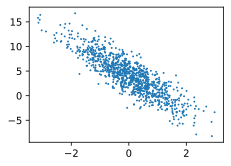

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

Definimos a função `data_iter`
que
leva um tamanho de amostra, uma matriz de *features*,
e um vetor de *labels*, produzindo *minibatches* do tamanho `batch_size`

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5128,  1.5159],
        [ 0.8435, -0.5366],
        [-2.0998, -0.5583],
        [-0.9732,  0.2785],
        [ 0.5156, -0.6750],
        [-0.9483, -0.8264],
        [ 1.1651, -1.1511],
        [-0.4142, -0.2177],
        [ 0.0096, -2.5156],
        [ 0.2120,  0.3262]]) 
 tensor([[-1.9986],
        [ 7.7304],
        [ 1.8992],
        [ 1.3037],
        [ 7.5153],
        [ 5.1295],
        [10.4260],
        [ 4.1079],
        [12.7557],
        [ 3.5010]])


Antes de começarmos a otimizar os parâmetros do nosso modelo
precisamos ter alguns parâmetros em primeiro lugar

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Definir nosso modelo,
relacionando suas entradas e parâmetros com suas saídas

In [9]:
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

Atualizar nosso modelo requer tomar
o gradiente de nossa função de perda,
definir a função de perda primeiro

In [10]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

Apesar da regressão linear ter uma solução de forma fechada, outros modelos neste livro não têm. Aqui, introduzimos o gradiente descendente estocástico de *minibatch*

In [11]:
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

Implementar o *loop* de treinamento principal

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040790
epoch 2, loss 0.000154


epoch 3, loss 0.000053


Avaliar nosso sucesso no treinamento
comparando os parâmetros verdadeiros
com aqueles que aprendemos

In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0002, -0.0006], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0005], grad_fn=<RsubBackward1>)
